In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

import torchvision
from torchvision import transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [ ]:
!nvidia-smi

Tue Sep  1 16:34:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    27W /  70W |    933MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## CIFAR-100 Data

In [ ]:
# TRANSFORMS
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.5, 1.0)), 
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761]),
])

transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761]),
])

# TRAIN DATA
train_set = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=transform_train)

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=128, shuffle=True, num_workers=2)

# VALIDATION DATA
val_set = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=True, transform=transform_test)

val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=128, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def imshow(img):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img.numpy().transpose((1, 2, 0))
    img = img * std + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.show()

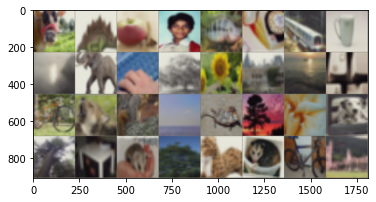

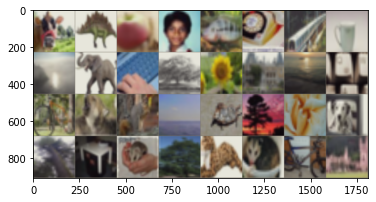

In [ ]:
# show some training images with shuffle=False
dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[:32]))

# show them again to check the augmentation
dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[:32]))

## Training utils

In [ ]:
def fit_epoch(model, data_loader, criterion, optimizer, train_mode=False):
    
    if train_mode:
      model.train()
    else:
      model.eval()

    epoch_losses = []
    running_loss = 0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in tqdm(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        with torch.set_grad_enabled(train_mode):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            if train_mode:
              loss.backward()
              optimizer.step()
            preds = torch.argmax(outputs, 1)

        epoch_losses += [loss.item()]
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
           
    epoch_loss = running_loss / processed_data
    epoch_acc = running_corrects.cpu().numpy() / processed_data
    
    if train_mode:
      print("train_loss: {:0.4f} | train_acc: {:0.4f}".format(epoch_loss, epoch_acc))
    else:
      print("  val_loss: {:0.4f} |   val_acc: {:0.4f}".format(epoch_loss, epoch_acc))

    return epoch_losses

In [ ]:
def train(train_loader, val_loader, model, epochs, lr=1e-3):
    
    all_train_losses, all_val_losses = [], []
    best_val_loss = float('inf')
    MODEL_SAVE_PATH = './model.pt'
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in tqdm(range(epochs)):
        print('EPOCH #', epoch+1)
        train_losses = fit_epoch(model, train_loader, criterion, optimizer, train_mode=True)
        val_losses   = fit_epoch(model, val_loader, criterion, optimizer, train_mode=False)

        all_train_losses += train_losses
        
        val_loss = np.array(val_losses).mean()
        all_val_losses += [val_loss]

        if val_loss < best_val_loss:
          best_val_loss = val_loss
          torch.save(model.state_dict(), MODEL_SAVE_PATH)

    return all_train_losses, all_val_losses

In [ ]:
def get_acc(model, val_loader):
    
    model.eval()
    running_corrects = 0
    processed_data = 0

    with torch.set_grad_enabled(False):
        for inputs, labels in tqdm(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = torch.argmax(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            processed_data += inputs.size(0)
           
    epoch_acc = running_corrects.cpu().numpy() / processed_data
    return epoch_acc

In [ ]:
def plot_losses(train_losses, val_losses, c_window=10):
    epochs = len(val_losses)
    train_losses_c = np.convolve(np.array(train_losses[:]),
                                np.ones(c_window)/c_window, mode='valid')

    plt.plot(train_losses_c, label='train_losses')
    plt.plot([i*len(train_losses)/epochs for i in range(1, epochs+1)], np.array(val_losses),
            label='val_losess', marker='o', markersize=8)
    plt.legend()
    plt.grid()
    plt.show();

## MobileNet V1

[MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications](https://arxiv.org/abs/1704.04861)

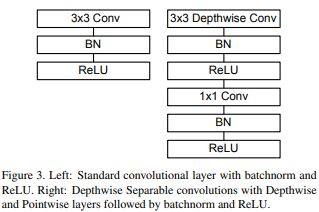



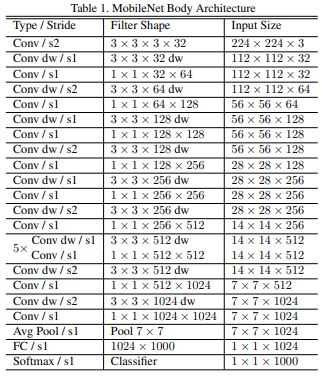


In [ ]:
class MobileNet(nn.Module):
    def __init__(self, n_class=1000):
        super().__init__()

        def conv_bn(inp, oup, stride):
            return nn.Sequential(
                nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True)
            )

        def conv_dw(inp, oup, stride):
            return nn.Sequential(
                # (inp, oup, kernel_size, stride, padding, groups, bias)
                nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
                nn.BatchNorm2d(inp),
                nn.ReLU(inplace=True),

                nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True),
            )

        self.model = nn.Sequential(
            conv_bn(  3,  32, 2), 
            conv_dw( 32,  64, 1),
            conv_dw( 64, 128, 2),
            conv_dw(128, 128, 1),
            conv_dw(128, 256, 2),
            conv_dw(256, 256, 1),
            conv_dw(256, 512, 2),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 1024, 2),
            conv_dw(1024, 1024, 1),
            nn.AvgPool2d(7),
        )
        self.fc = nn.Linear(1024, n_class)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

In [ ]:
model = MobileNet(n_class=100).to(device)
epochs = 10
lr = 1e-3
train_losses, val_losses = train(train_loader, val_loader, model, epochs, lr)

EPOCH # 1



train_loss: 3.7522 | train_acc: 0.1186



  val_loss: 3.3338 |   val_acc: 0.1902
EPOCH # 2



train_loss: 2.9521 | train_acc: 0.2595



  val_loss: 2.6944 |   val_acc: 0.3186
EPOCH # 3



train_loss: 2.4603 | train_acc: 0.3563



  val_loss: 2.3913 |   val_acc: 0.3828
EPOCH # 4



train_loss: 2.1266 | train_acc: 0.4323



  val_loss: 2.0740 |   val_acc: 0.4447
EPOCH # 5



train_loss: 1.9006 | train_acc: 0.4846



  val_loss: 1.8874 |   val_acc: 0.4867
EPOCH # 6



train_loss: 1.7126 | train_acc: 0.5271



  val_loss: 1.7953 |   val_acc: 0.5136
EPOCH # 7



train_loss: 1.5608 | train_acc: 0.5660



  val_loss: 1.6966 |   val_acc: 0.5365
EPOCH # 8



train_loss: 1.4411 | train_acc: 0.5952



  val_loss: 1.5842 |   val_acc: 0.5573
EPOCH # 9



train_loss: 1.3339 | train_acc: 0.6206



  val_loss: 1.5357 |   val_acc: 0.5744
EPOCH # 10



train_loss: 1.2344 | train_acc: 0.6465



  val_loss: 1.4389 |   val_acc: 0.6046



In [ ]:
start = time.time()
val_acc = get_acc(model, val_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start) )


Batch_size=128, epochs=10, lr=0.001
Val accuracy = 0.6046
Process validation time: 17.9651 s


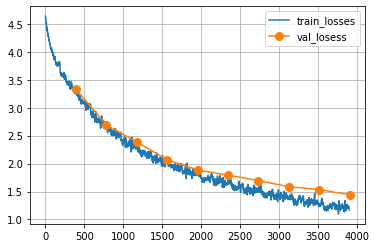

In [ ]:
plot_losses(train_losses, val_losses)

## MobileNet V2

[MobileNetV2: Inverted Residuals and Linear Bottlenecks](https://arxiv.org/abs/1801.04381)

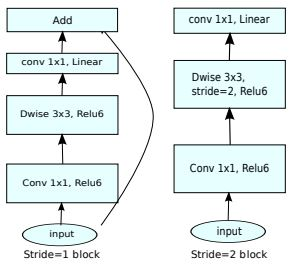


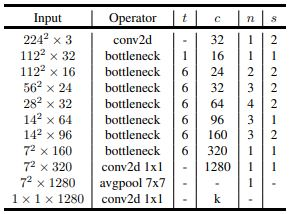


In [ ]:
def conv_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )


def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()

        self.use_res_connect = (stride == 1) and (inp == oup)
        hidden_dim = int(inp * expand_ratio)

        if expand_ratio == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV2(nn.Module):
    def __init__(self, n_class=1000, input_size=224):
        super(MobileNetV2, self).__init__()
        
        input_channel = 32
        interverted_residual_setting = [# t, c, n, s
                                        [1, 16, 1, 1],
                                        [6, 24, 2, 2],
                                        [6, 32, 3, 2],
                                        [6, 64, 4, 2],
                                        [6, 96, 3, 1],
                                        [6, 160, 3, 2],
                                        [6, 320, 1, 1] ]
        last_channel = 1280

        # building first layer
        self.features = [conv_bn(3, input_channel, 2)]

        # building inverted residual blocks
        block = InvertedResidual
        for t, c, n, s in interverted_residual_setting:
            output_channel = c
            for i in range(n):
                if i == 0:
                    self.features.append(block(input_channel, output_channel, s, expand_ratio=t))
                else:
                    self.features.append(block(input_channel, output_channel, 1, expand_ratio=t))
                input_channel = output_channel

        # building last several layers
        self.features.append(conv_1x1_bn(input_channel, last_channel))

        # make it nn.Sequential
        self.features = nn.Sequential(*self.features)

        # building classifier
        self.classifier = nn.Linear(last_channel, n_class)

    def forward(self, x):
        x = self.features(x)
        x = x.mean(3).mean(2)
        x = self.classifier(x)
        return x

In [ ]:
model = MobileNetV2(n_class=100).to(device)
epochs = 10
lr = 1e-3
train_losses, val_losses = train(train_loader, val_loader, model, epochs, lr)

EPOCH # 1



train_loss: 3.8004 | train_acc: 0.1050



  val_loss: 3.6602 |   val_acc: 0.1417
EPOCH # 2



train_loss: 3.1178 | train_acc: 0.2154



  val_loss: 2.8844 |   val_acc: 0.2680
EPOCH # 3



train_loss: 2.6768 | train_acc: 0.3067



  val_loss: 2.6778 |   val_acc: 0.3195
EPOCH # 4



train_loss: 2.3656 | train_acc: 0.3726



  val_loss: 2.2988 |   val_acc: 0.3956
EPOCH # 5



train_loss: 2.1439 | train_acc: 0.4213



  val_loss: 2.2392 |   val_acc: 0.4126
EPOCH # 6



train_loss: 1.9611 | train_acc: 0.4631



  val_loss: 2.0217 |   val_acc: 0.4549
EPOCH # 7



train_loss: 1.8176 | train_acc: 0.5008



  val_loss: 2.0073 |   val_acc: 0.4648
EPOCH # 8



train_loss: 1.6929 | train_acc: 0.5292



  val_loss: 1.8067 |   val_acc: 0.5059
EPOCH # 9



train_loss: 1.5965 | train_acc: 0.5494



  val_loss: 1.7590 |   val_acc: 0.5198
EPOCH # 10



train_loss: 1.5012 | train_acc: 0.5756



  val_loss: 1.7419 |   val_acc: 0.5285



In [ ]:
start = time.time()
val_acc = get_acc(model, val_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start) )


Batch_size=128, epochs=10, lr=0.001
Val accuracy = 0.5285
Process validation time: 17.9623 s


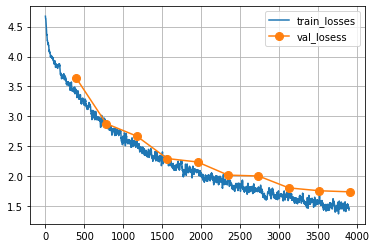

In [ ]:
plot_losses(train_losses, val_losses)

## MobileNet V3

[Searching for MobileNetV3](https://arxiv.org/abs/1905.02244)

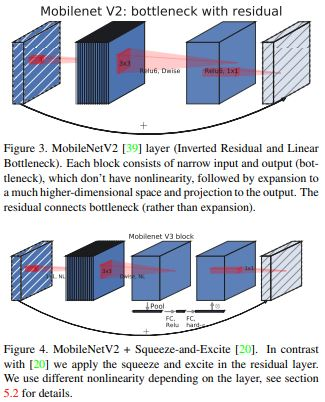

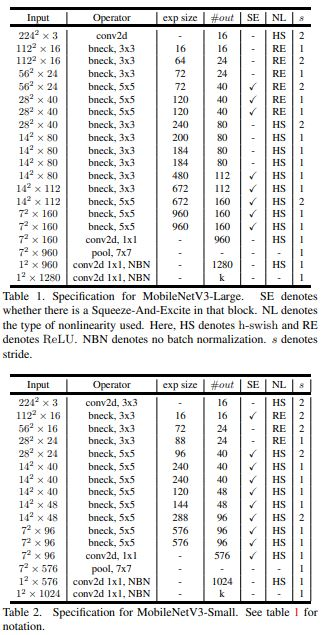

In [ ]:
class h_sigmoid(nn.Module):
    def __init__(self, inplace=True):
        super(h_sigmoid, self).__init__()
        self.relu6 = nn.ReLU6(inplace=inplace)
    def forward(self, x):
        return self.relu6(x + 3) / 6


class h_swish(nn.Module):
    def __init__(self, inplace=True):
        super(h_swish, self).__init__()
        self.hsigmoid = h_sigmoid(inplace=inplace)
    def forward(self, x):
        return x * self.hsigmoid(x)


class SqueezeBlock(nn.Module):
    def __init__(self, exp_size, divide=4):
        super(SqueezeBlock, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(exp_size, exp_size // divide),
            nn.ReLU(inplace=True),
            nn.Linear(exp_size // divide, exp_size),
            h_sigmoid()
        )

    def forward(self, x):
        batch, channels, height, width = x.size()
        out = F.avg_pool2d(x, kernel_size=[height, width]).view(batch, -1)
        out = self.dense(out)
        out = out.view(batch, channels, 1, 1)
        return out * x


class MobileBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernal_size, stride, nonLinear, SE, exp_size):
        super(MobileBlock, self).__init__()
        self.out_channels = out_channels
        self.nonLinear = nonLinear
        self.SE = SE
        padding = (kernal_size - 1) // 2

        self.use_connect = (stride == 1) and (in_channels == out_channels)

        if self.nonLinear == "RE":
            activation = nn.ReLU
        else:
            activation = h_swish

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, exp_size, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(exp_size),
            activation(inplace=True)
        )
        self.depth_conv = nn.Sequential(
            nn.Conv2d(exp_size, exp_size, kernel_size=kernal_size, stride=stride, padding=padding, groups=exp_size),
            nn.BatchNorm2d(exp_size),
        )

        if self.SE:
            self.squeeze_block = SqueezeBlock(exp_size)

        self.point_conv = nn.Sequential(
            nn.Conv2d(exp_size, out_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(out_channels),
            activation(inplace=True)
        )

    def forward(self, x):
        # MobileNetV2
        out = self.conv(x)
        out = self.depth_conv(out)

        # Squeeze and Excite
        if self.SE:
            out = self.squeeze_block(out)

        # point-wise conv
        out = self.point_conv(out)

        # connection
        if self.use_connect:
            return x + out
        else:
            return out


class MobileNetV3Small(nn.Module):
    def __init__(self, n_class=1000):
        super(MobileNetV3Small, self).__init__()
        
        self.n_class = n_class

        layers = [
            [16, 16, 3, 2, "RE", True, 16],
            [16, 24, 3, 2, "RE", False, 72],
            [24, 24, 3, 1, "RE", False, 88],
            [24, 40, 5, 2, "RE", True, 96],
            [40, 40, 5, 1, "RE", True, 240],
            [40, 40, 5, 1, "RE", True, 240],
            [40, 48, 5, 1, "HS", True, 120],
            [48, 48, 5, 1, "HS", True, 144],
            [48, 96, 5, 2, "HS", True, 288],
            [96, 96, 5, 1, "HS", True, 576],
            [96, 96, 5, 1, "HS", True, 576],
        ]

        self.init_conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            h_swish(inplace=True),
        )

        self.block = []
        for in_channels, out_channels, kernal_size, stride, nonlinear, se, exp_size in layers:
            self.block.append(MobileBlock(in_channels, out_channels, kernal_size, stride, nonlinear, se, exp_size))
        self.block = nn.Sequential(*self.block)


        self.out_conv = nn.Sequential(
            nn.Conv2d(96, 576, kernel_size=1, stride=1),
            SqueezeBlock(576),
            nn.BatchNorm2d(576),
            h_swish(inplace=True),

            nn.AdaptiveAvgPool2d(1),

            nn.Conv2d(576, 1024, kernel_size=1, stride=1),
            h_swish(inplace=True),
            nn.Conv2d(1024, self.n_class, kernel_size=1, stride=1),
        )


    def forward(self, x):
        out = self.init_conv(x)
        out = self.block(out)
        out = self.out_conv(out)
        out = out.view(out.shape[0], -1)
        return out

In [ ]:
model = MobileNetV3Small(n_class=100).to(device)
epochs = 10
lr = 1e-3
train_losses, val_losses = train(train_loader, val_loader, model, epochs, lr)

EPOCH # 1



train_loss: 3.8079 | train_acc: 0.1068



  val_loss: 3.5447 |   val_acc: 0.1504
EPOCH # 2



train_loss: 3.1733 | train_acc: 0.2138



  val_loss: 3.0675 |   val_acc: 0.2353
EPOCH # 3



train_loss: 2.7374 | train_acc: 0.2969



  val_loss: 2.6351 |   val_acc: 0.3211
EPOCH # 4



train_loss: 2.4202 | train_acc: 0.3626



  val_loss: 2.3515 |   val_acc: 0.3807
EPOCH # 5



train_loss: 2.1869 | train_acc: 0.4154



  val_loss: 2.1202 |   val_acc: 0.4245
EPOCH # 6



train_loss: 2.0020 | train_acc: 0.4543



  val_loss: 2.0456 |   val_acc: 0.4487
EPOCH # 7



train_loss: 1.8538 | train_acc: 0.4908



  val_loss: 1.9114 |   val_acc: 0.4931
EPOCH # 8



train_loss: 1.7127 | train_acc: 0.5208



  val_loss: 1.8147 |   val_acc: 0.5049
EPOCH # 9



train_loss: 1.5911 | train_acc: 0.5515



  val_loss: 1.7607 |   val_acc: 0.5158
EPOCH # 10



train_loss: 1.4921 | train_acc: 0.5749



  val_loss: 1.7076 |   val_acc: 0.5333



In [ ]:
start = time.time()
val_acc = get_acc(model, val_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start) )


Batch_size=128, epochs=10, lr=0.001
Val accuracy = 0.5333
Process validation time: 17.3701 s


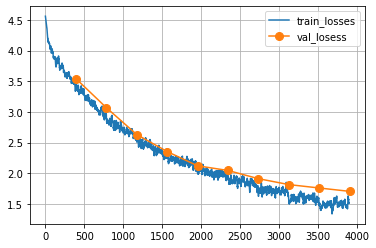

In [ ]:
plot_losses(train_losses, val_losses)

### More training

In [ ]:
# MORE TRAINING
epochs = 10
lr = 1e-3
more_train_losses, more_val_losses = train(train_loader, val_loader, model, epochs, lr)

EPOCH # 1



train_loss: 1.4004 | train_acc: 0.6001



  val_loss: 1.6410 |   val_acc: 0.5520
EPOCH # 2



train_loss: 1.3016 | train_acc: 0.6234



  val_loss: 1.5604 |   val_acc: 0.5755
EPOCH # 3



train_loss: 1.2337 | train_acc: 0.6418



  val_loss: 1.5863 |   val_acc: 0.5710
EPOCH # 4



train_loss: 1.1622 | train_acc: 0.6580



  val_loss: 1.5341 |   val_acc: 0.5833
EPOCH # 5



train_loss: 1.0947 | train_acc: 0.6759



  val_loss: 1.5747 |   val_acc: 0.5804
EPOCH # 6



train_loss: 1.0330 | train_acc: 0.6933



  val_loss: 1.6171 |   val_acc: 0.5788
EPOCH # 7



train_loss: 0.9801 | train_acc: 0.7074



  val_loss: 1.5126 |   val_acc: 0.6015
EPOCH # 8



train_loss: 0.9242 | train_acc: 0.7210



  val_loss: 1.5284 |   val_acc: 0.6011
EPOCH # 9



train_loss: 0.8676 | train_acc: 0.7370



  val_loss: 1.5229 |   val_acc: 0.6082
EPOCH # 10



train_loss: 0.8162 | train_acc: 0.7491



  val_loss: 1.5103 |   val_acc: 0.6141



In [ ]:
model.load_state_dict(torch.load('./model.pt'))

start = time.time()
val_acc = get_acc(model, val_loader)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs*2, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start) )


Batch_size=128, epochs=20, lr=0.001
Val accuracy = 0.6015
Process validation time: 17.0053 s


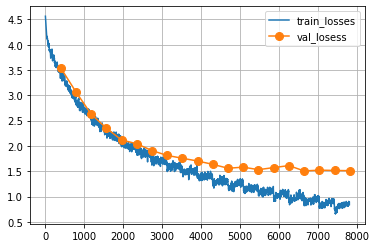

In [ ]:
train_losses += more_train_losses
val_losses += more_val_losses

plot_losses(train_losses, val_losses)

## Comparison

The aim of this comparison is not to evaluate the accuracy of different models, but to compare weights' memory size and training/validation time per epoch.

In [ ]:
import pandas as pd

data = [['3:03', '0:18', 12.7, 0.6046],
        ['3:30', '0:18',  9.2, 0.5285],
        ['1:48', '0:17', 6.95, 0.5333]]

df = pd.DataFrame(data, index=['mobilenet_v'+str(i) for i in range(1,4)],
                  columns=['Train_time', 'Val_time', 'Memory,Mb', 'Accuracy after 10 epochs'])

print('Params for all models: batch_size={}, epochs={}, lr={}'.format(128, 10, 0.001))
df.head()

Params for all models: batch_size=128, epochs=10, lr=0.001


,Train_time,Val_time,"Memory,Mb",Accuracy after 10 epochs
mobilenet_v1,3:03,0:18,12.70,0.6046
mobilenet_v2,3:30,0:18,9.20,0.5285
mobilenet_v3,1:48,0:17,6.95,0.5333


## Test data from image folder

In [ ]:
import numpy as np
import time

import torchvision
from torchvision import transforms

import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [ ]:
!unzip -q ./test_folder.zip

In [ ]:
transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761]),
    ])

# TEST DATA FROM IMAGE FOLDER
test_folder_path = './test_folder'
test_set = torchvision.datasets.ImageFolder(test_folder_path, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False)

In [ ]:
# MODEL LOADING
MODEL_SAVE_PATH = './mobilenetv3small.pt'
model = MobileNetV3Small(n_class=100).to(device)
model.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In [ ]:
# import torchsummary
# torchsummary.summary(model, (3, 224, 224))

In [ ]:
def make_predictions(model, test_loader):

    model.eval()
    predictions = []

    with torch.set_grad_enabled(False):
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = outputs.data.cpu().numpy().argmax(1)
            predictions += list(preds)

    return predictions

In [ ]:
start = time.time()
predictions = make_predictions(model, test_loader)
end = time.time()

print("Predictions:", predictions)
print("Process time per image: {:0.4f} ms".format((end - start)/len(test_set)*1e3) )

Predictions: [68, 16, 91, 44, 92, 41, 8]
Process time per image: 24.3436 ms


Requirements:

In [ ]:
pip freeze > requirements.txt

Запуск текстового скрипта:

In [ ]:
from main import main
main()

Predictions: [68, 16, 91, 44, 92, 41, 8]
Process time per image: 26.3067 ms
